# Blood Transfusion Donations

## About Dataset

This blood donation dataset came from the UCI repository. They provide a wide range of datasets for testing machine learning algorithms. Finding a subject matter you're interested in can be a great way to test yourself on real-world data problems. Given our mission, we're interested in predicting if a blood donor will donate within a given time window.

Use information about each donor's history

* Months since Last Donation: this is the number of monthis since this donor's most recent donation.

* Number of Donations: this is the total number of donations that the donor has made.
Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.

* Months since First Donation: this is the number of months since the donor's first donation.
Submission format

This competitions uses log loss as its evaluation metric, so the predictions you submit are the probability that a donor made a donation in March 2007.

## Task


Predict if the donor will give in March 2007
The goal is to predict the last column, whether he/she donated blood in March 2007 with log-probabilities. Build out multiple classifiers with a variety of models, with validation, and keep track of the scores and performances via a pandas dataframe and writeout to csv. 



## Loading Data

In [2]:
# Accessory modules
from collections import Counter
from inspect import signature
import pandas as pd
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
from google.colab import drive
FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/transfusion.data"
DRIVE = "/content/drive/"
drive.mount(DRIVE)
import pandas_profiling
from timeit import default_timer
import warnings
warnings.filterwarnings("ignore")
import tempfile

# Scikit-learn Modules
from sklearn.metrics import (precision_score, confusion_matrix, recall_score, accuracy_score, 
                             balanced_accuracy_score,roc_auc_score, classification_report, confusion_matrix, 
                             r2_score, f1_score, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# Keras Modules
from tensorflow import keras
from tensorflow.keras.metrics import (TruePositives, FalsePositives, TrueNegatives, 
                                      FalseNegatives, BinaryAccuracy, Precision, Recall, AUC)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, 
                          BatchNormalization, Dropout)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import Constant
from tensorflow import data

# Plotting modules
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Constants and Variables

In [0]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

EPOCHS = 100
BATCH_SIZE = int(np.ceil(748/10))

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)



## Functions

In [0]:
def split_positive_negative(dataframe, target="target"):
    positive_cases = dataframe.loc[dataframe[target]==1, :]
    negative_cases = dataframe.loc[dataframe[target]==0, :]
    return positive_cases, negative_cases

def split_dataset(df, target="target"):
    # Use a utility from sklearn to split and shuffle our dataset.
    seed = 42
    test_size=0.3
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed)
    train_df, val_df = train_test_split(train_df, test_size=test_size, random_state=seed)

    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop(target))
    bool_y_train = y_train != 0
    y_val = np.array(val_df.pop(target))
    y_test = np.array(test_df.pop(target))

    X_train = np.array(train_df)
    X_val = np.array(val_df)
    X_test = np.array(test_df)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def standardize_data(train_features, val_features, test_features):
    scaler = StandardScaler()

    # fit scaler for each of their respective splits so that we don't cross contaminate
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    # train_features = np.clip(train_features, -5, 5)
    # val_features = np.clip(val_features, -5, 5)
    # test_features = np.clip(test_features, -5, 5)

    print('Training features shape:', train_features.shape)
    print('Validation features shape:', val_features.shape)
    print('Test features shape:', test_features.shape)

    return train_features, val_features, test_features


def get_max_probas(y_pred_probs):
    """ get array of target probabilities and return an array of 
    prediicted max probabilities for a binary class problem """
    df = pd.DataFrame(y_pred_probs)
    df['max'] = df.max(axis=1)
    y_pred_probs_max = df['max'].values
    return y_pred_probs_max


def make_model(train_features, metrics = METRICS, output_bias=None):
    """ simple neural network model to classify anomalous vs nominal cases """
    if output_bias is not None:
        output_bias = Constant(output_bias)
    
    model = Sequential([
        Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid',bias_initializer=output_bias),
    ])


    model.compile(
        optimizer=Adam(lr=1e-3),
        loss=BinaryCrossentropy(),
        metrics=metrics)

    return model


def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall', "fn"]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(cm, annot=True, fmt="d", ax=ax)
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


def plot_roc_curve(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


In [0]:
df = pd.read_csv(FILENAME, header="infer")
df.rename(columns={"whether he/she donated blood in March 2007" : "target"}, inplace=True)

In [0]:
# scale the blood amounts
df['log_blood_amount'] = np.log(df.pop("Monetary (c.c. blood)")+0.001)

# Exploratory Data Analysis

## Quick profilling with Pandas Profiler

What can be gleened:

* data not normally distributed
* nice and clean and little to no preprocessing is required for this dataset
* no encoding needed
* no missing values
* all numeric variables and one binary target attribute
* one highly correlated feature rejected
    * Amount of blood is highly correlated with the Frequency (times) attribute and the frequency column is rejected
* We will have to drop the frequency column
* the majority of values are non-zero

In [0]:
report = pandas_profiling.ProfileReport(df)
report

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,748
Total Missing (%),0.0%
Total size in memory,29.3 KiB
Average record size in memory,40.2 B
Numeric,3
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [0]:
report.to_file(outputfile="blood_transfusion_classification_pandasprofiling.html")

## Quick Distribution plotting

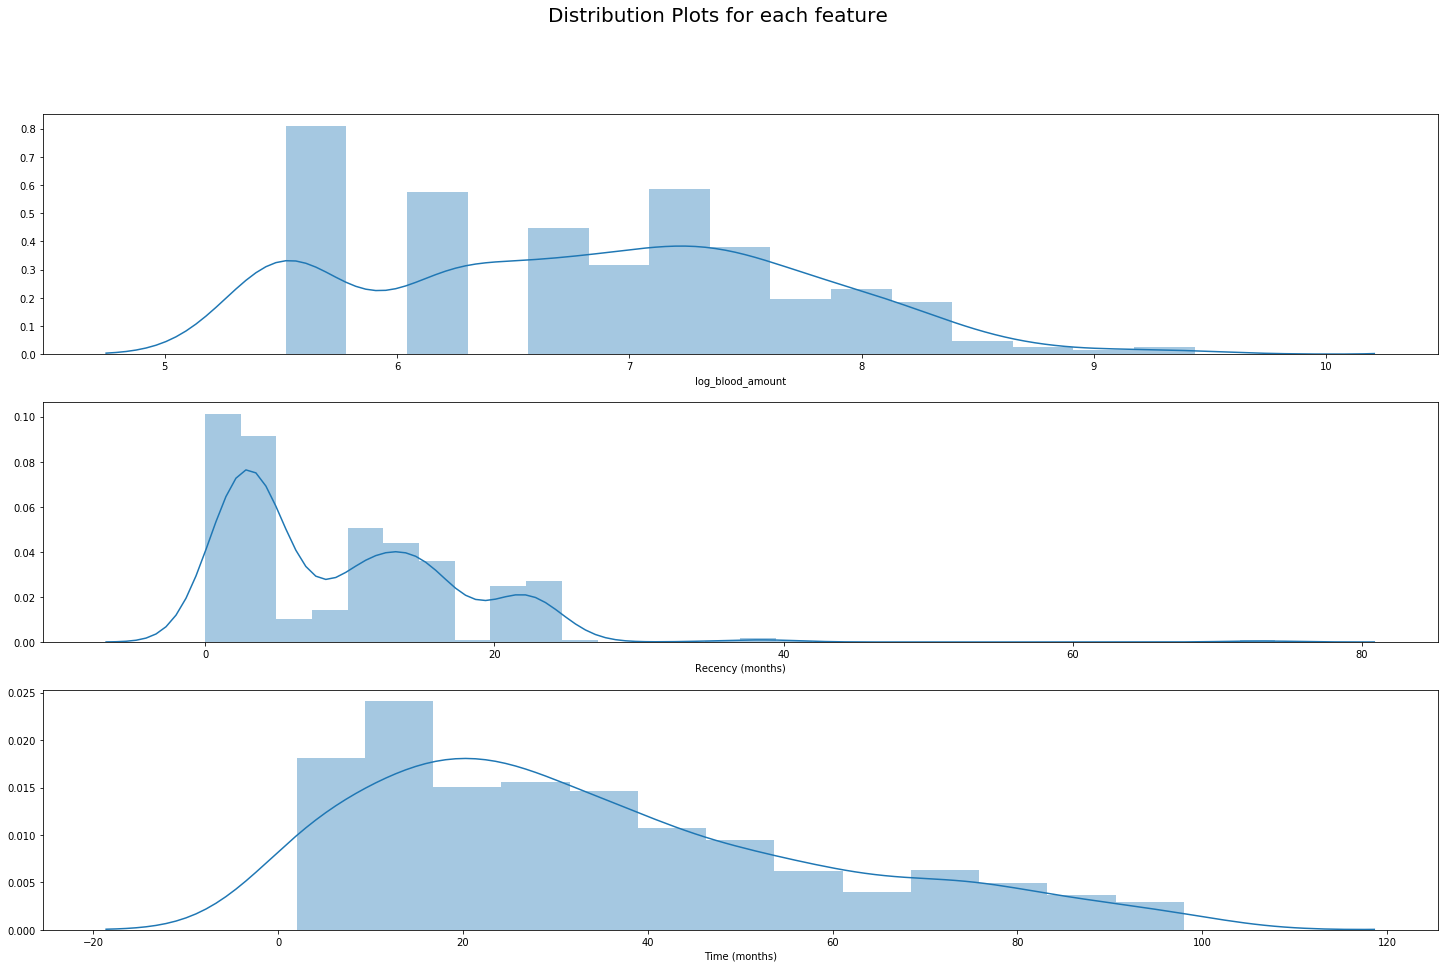

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(25, 15))
fig.suptitle('Distribution Plots for each feature', fontsize=20)
sns.distplot(df['log_blood_amount'], hist=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('log_blood_amount', fontsize=10)
sns.distplot(df['Recency (months)'], hist=True, norm_hist=True, ax=ax2)
ax2.set_xlabel('Recency (months)', fontsize=10)
sns.distplot(df['Time (months)'], hist=True, norm_hist=True, ax=ax3)
plt.show()

## Quick histogram plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b93973978>,
      dtype=object)

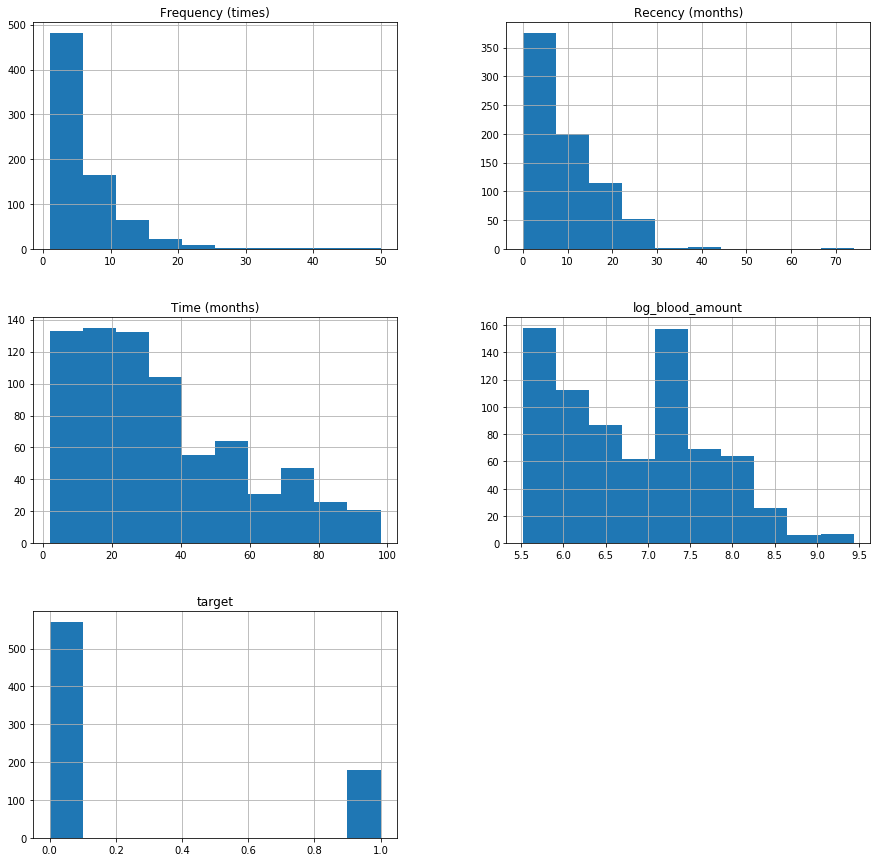

In [21]:
pd.DataFrame.hist(df, figsize = [15,15])

## Drop highly correlated variables

In [0]:
df.drop('Frequency (times)', axis=1, inplace=True)

## Feature selection

### Variance Threshold Feature Selection

In [0]:
def select_features_var_threshold(dataframe, threshold):
    """ Features with a training-set variance lower than this threshold will be removed.  """
    from sklearn.feature_selection import VarianceThreshold
    from timeit import default_timer

    X, y = dataframe.iloc[:, :-1].values, dataframe.iloc[:, -1].values
    start = default_timer()
    var_threshold = VarianceThreshold(threshold)
    var_threshold.fit(X)
    X_new = var_threshold.transform(X)
    end = default_timer()
    print("Elapsed Time for feature selection: {}s".format(end-start))
    return X_new

new_selected_features = select_features_var_threshold(df, threshold=0.7)
print(f"Variance Thresheld Selected Features: {new_selected_features}")

Elapsed Time for feature selection: 0.00031017599985716515s
Variance Thresheld Selected Features: [[    2 12500    98]
 [    0  3250    28]
 [    1  4000    35]
 ...
 [   23   750    62]
 [   39   250    39]
 [   72   250    72]]


Using variance threshold feature selection, with a threshold of 0.7, our feature selection class kept all the features and the RandomForestClassifier returned the same scores as it out have produced without the feature selection, out of the box.

The R-squared coefficient is 0.92+ which is really high, which means that this model does really well out of the box. Because the number of feature in this dataset are so little, we decide to just keep all the features in the dataset.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer

X = df.iloc[:, :-1].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

rfc = RandomForestClassifier()
start = default_timer()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_probs = rfc.predict_proba(X_test)
y_pred_probs = get_max_probas(y_pred_probs)
print("coefficient of determination R^2 of our estimator out of the box: {}".format(rfc.score(X_train, y_train)))
end = default_timer()
print("Total training time: {}s".format(end-start))

coefficient of determination R^2 of our estimator out of the box: 1.0
Total training time: 0.029125942000064242s


In [28]:
from sklearn.metrics import confusion_matrix as cm
cm = cm(y_test, y_pred, labels=None, sample_weight=None)
cm

array([[165,   0],
       [  0,  60]])

We've created a perfect model! But we should be skeptical of this. We have overfitted somehow.

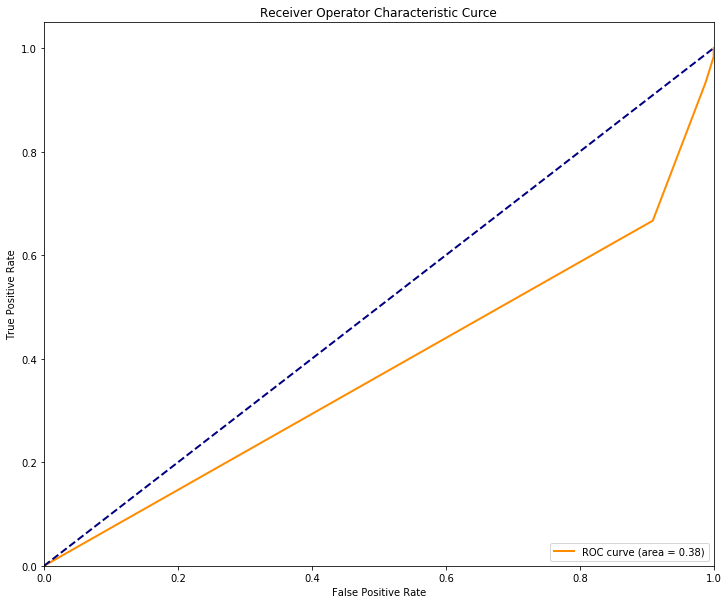

In [30]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

Our ROC curve gives us results that are indicative of a class imbalance, and our confusion matrix gives us perfect predictions, meaning that we are overfitting. Let's try a different approach here and use a different type of splitting  for the dataset

## Split dataset into train val test

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(df, target="target")

In [47]:
# standardize features
X_train, X_val, X_test = standardize_data(X_train, X_val, X_test)

Training features shape: (366, 3)
Validation features shape: (157, 3)
Test features shape: (225, 3)


## Using Class weights for initial bias

It is said that initializing the class weights to reflect the differences in class imbalance allows a model to penalize more effectively on majority case prediction errors and encourage correction for errors made from incorrect predictions of the minority positive case.

We can get this initial bias by taking the log of the ratio of positive cases to negative cases:



```
np.log([pos/neg])
```



In [43]:
df.target.value_counts()

0    570
1    178
Name: target, dtype: int64

In [44]:
initial_bias = np.log([df['target'].value_counts()[1]/df['target'].value_counts()[0]])
initial_bias

array([-1.16385281])

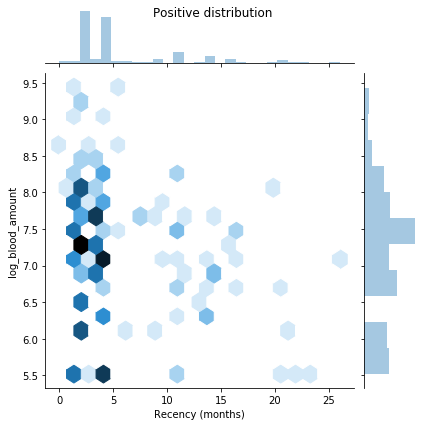

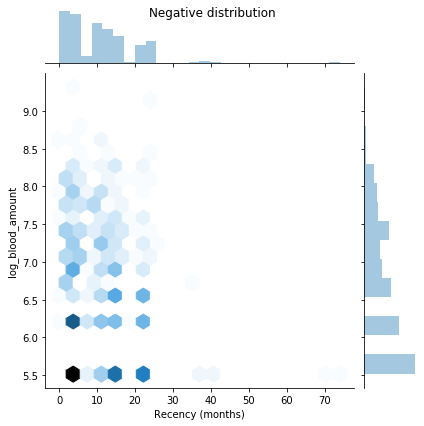

In [52]:
# look at a pairwise distribution of the values in two features using a joint hex plot

pos_df = pd.DataFrame(df.loc[df.target==1, df.columns[df.columns != "Class"]], columns = df.columns[df.columns != "Class"])
neg_df = pd.DataFrame(df.loc[df.target==0, df.columns[df.columns != "Class"]], columns = df.columns[df.columns != "Class"])

sns.jointplot(pos_df['Recency (months)'], pos_df['log_blood_amount'],
              kind='hex')
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Recency (months)'], neg_df['log_blood_amount'],
              kind='hex')
_ = plt.suptitle("Negative distribution")

## Baseline NN model

Modeled with and without bias correction for imbalanced classses.

In [81]:
model = make_model(X_train, METRICS, output_bias=initial_bias)
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5610


In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [0]:
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [0]:
model = make_model(train_features=X_train)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0)

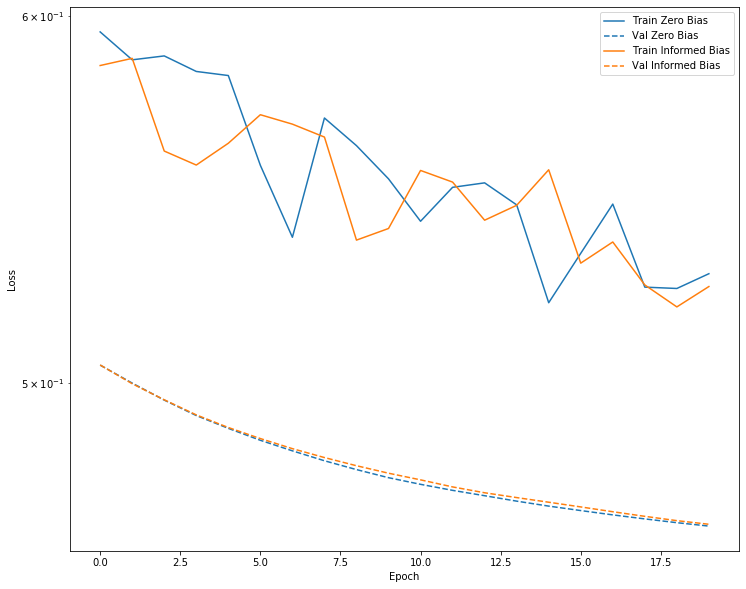

In [85]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Informed Bias", 1)

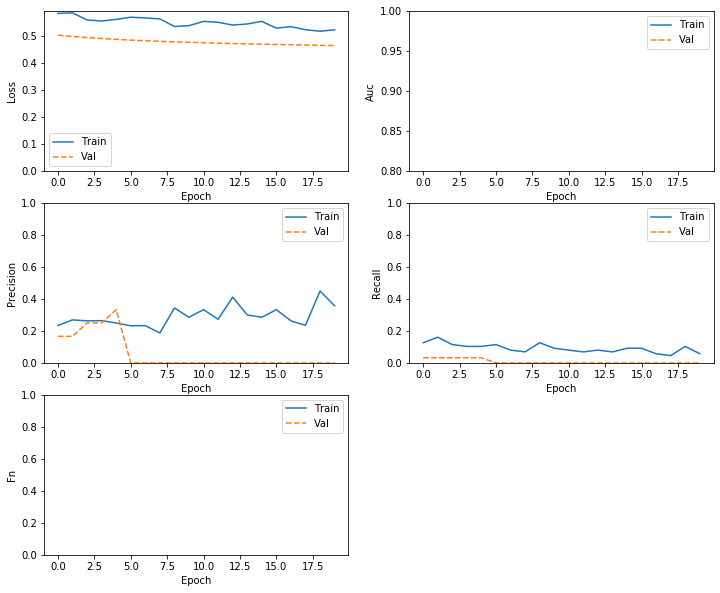

In [86]:
plot_metrics(careful_bias_history)

In [0]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.541803777217865
tp :  0.0
fp :  0.0
tn :  165.0
fn :  60.0
accuracy :  0.73333335
precision :  0.0
recall :  0.0
auc :  0.6830303

Legitimate Transactions Detected (True Negatives):  165
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  60
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  60


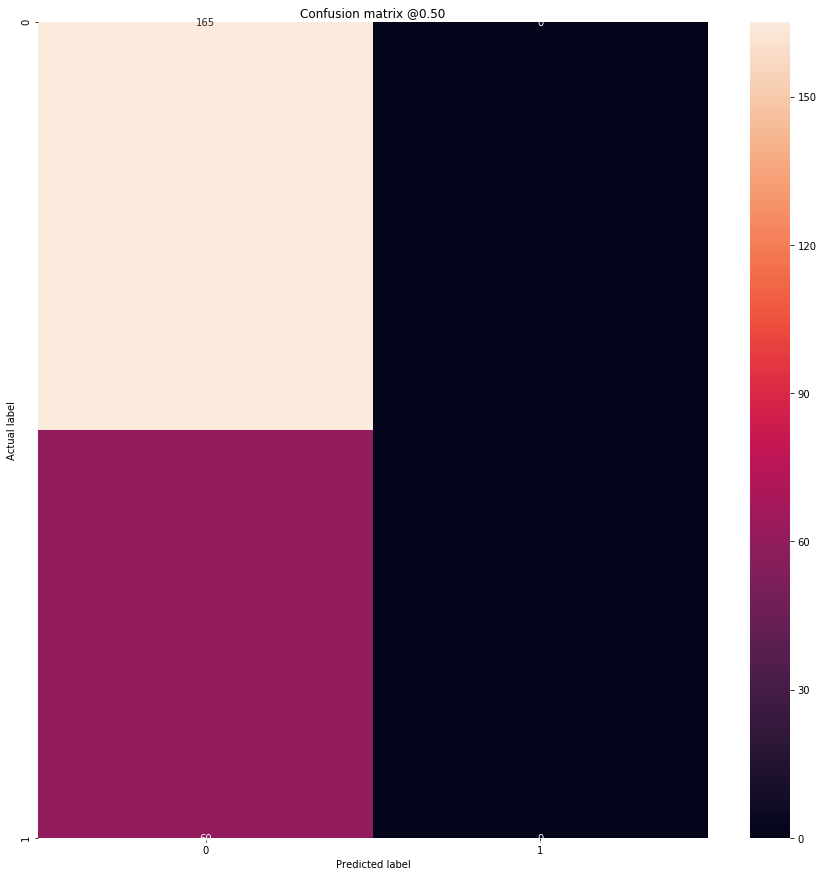

In [88]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

## NN Model with corrected class weighting

Use different weighting to emphasize correctness of predictions for positive cases.

In [95]:
#changing class

weight_for_0 = (1 / df['target'].value_counts()[0]) * ((df.shape[0])/2.0)
weight_for_1 = (1 / df['target'].value_counts()[1]) * ((df.shape[0])/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 2.10


In [105]:
resampled_steps_per_epoch = np.ceil(2.0*df['target'].value_counts()[0]/BATCH_SIZE)
print(f"Num steps per epoch: {int(resampled_steps_per_epoch)}")

Num steps per epoch: 16


In [157]:
weighted_model = make_model(train_features=X_train)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(resampled_steps_per_epoch)*2,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f9b57393198> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f9b57393828>).
Train on 32 samples, validate on 157 samples
Epoch 1/100
32/32 [==============================] - 3s 109ms/step - loss: 0.6081 - tp: 2229.0000 - fp: 4203.0000 - tn: 4725.0000 - fn: 555.0000 - accuracy: 0.5938 - precision: 0.3465 - recall: 0.8006 - auc: 0.7531 - val_loss: 0.6675 - val_tp: 20.0000 - val_fp: 57.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.5669 - val_precision: 0.2597 - val_recall: 0.6452 - val_auc: 0.6562
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.5890 - tp: 2143.0000 - fp: 3600.0000 - tn: 5328.0000 - fn: 641.0000 - accuracy: 0.6379 - precision: 0.3731 - recall: 0.7698 - auc: 0.7650 - val_loss: 0.6367 - val_tp: 17.0000 - val_fp: 35.0000 - val_tn: 91.0000 - val_fn: 14.0000 - val_accuracy: 0.6879 - val_prec

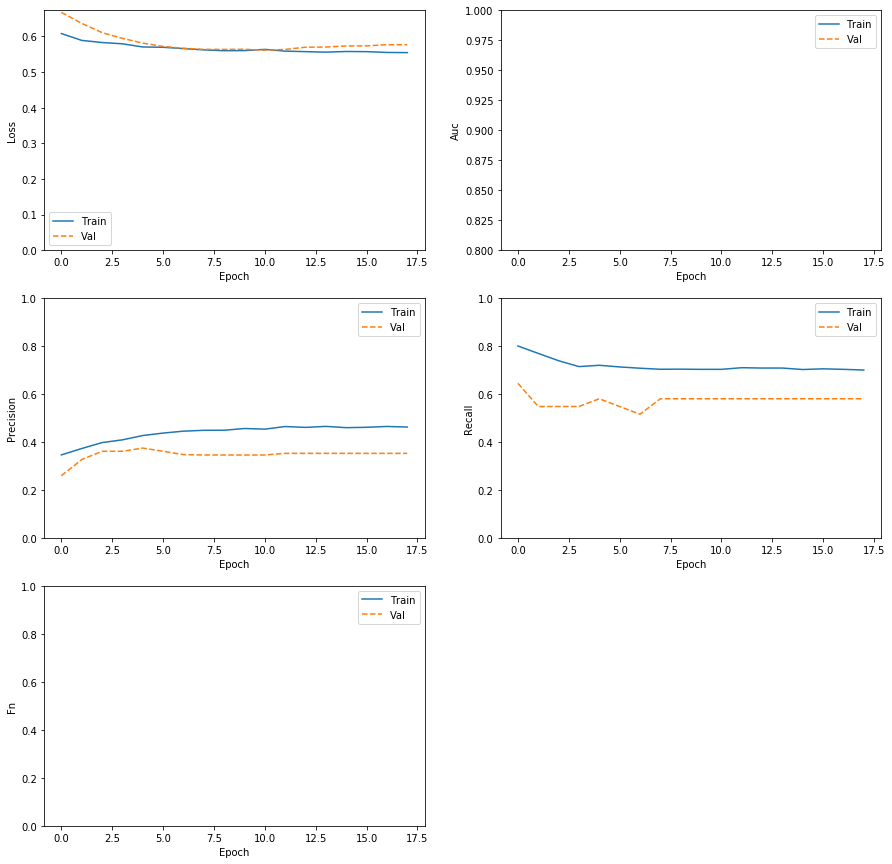

In [158]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_metrics(weighted_history)

Look at the other evaluation metrics using the test set

In [0]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.5748244921366373
tp :  40.0
fp :  46.0
tn :  119.0
fn :  20.0
accuracy :  0.70666665
precision :  0.4651163
recall :  0.6666667
auc :  0.7593434

Legitimate Transactions Detected (True Negatives):  119
Legitimate Transactions Incorrectly Detected (False Positives):  46
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  40
Total Fraudulent Transactions:  60


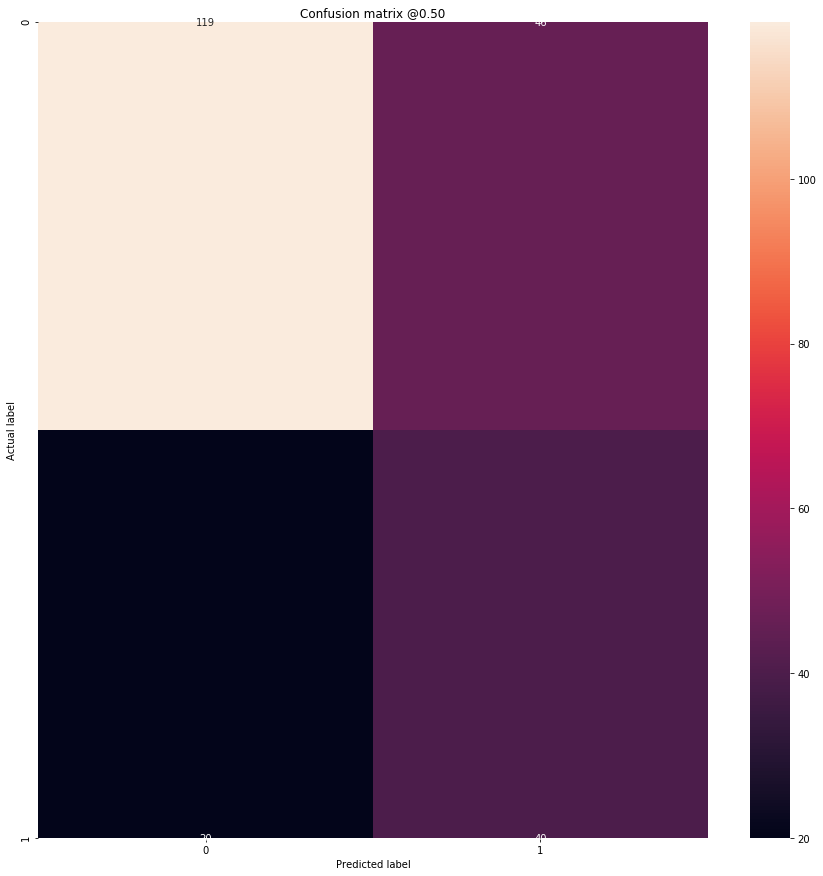

In [160]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

The validation results for the model were promising, however, it is clear from this confusion matrix, recall, and sensitivity of this model that we missed-classified identifying those who had donated as non-donors. As a result, we are missing out on potentially reaching out to 30% of the donors that come in. We also incorrectly reach out to 46 people, predicting that they have donated blood in May 2007 when they have not.

## Classic based Machine Learning Methods

### Hypothesis testing

I want to perform a little bit more data exploration and statistical testing of hypothesis testing to see whether or not a strong statistical relationship exists between dependent and independent variables. After having plotted the distribution of each of the feature values, we know that we are dealing with a non-normal distribution and therefore a non-parametric approach to hypothesis testing must be pursued.

From the Kruskal Wallis test, we can see that there is a difference in the median  Recency and the total blood donated values, for those who have donated their blood in March 2007 and those who did not. There is, however, no difference between the donor and non-donor groups in terms of the months since last donation (as time since last donatio is intuitively independent).

In [0]:
from scipy.stats import kruskal

for col in df.columns[df.columns != "target"]:
    print("{}: {}".format(col, kruskal(df.loc[df.target==1, col],
                            df.loc[df.target ==0, col])))

Recency (months): KruskalResult(statistic=65.28504036601454, pvalue=6.48114733861018e-16)
Monetary (c.c. blood): KruskalResult(statistic=35.10221854273894, pvalue=3.128441735961902e-09)
Time (months): KruskalResult(statistic=0.5894765141978687, pvalue=0.4426216188460801)


## Dimensionality Reduction with PCA

Best parameter (CV score=0.675):
{'logistic__alpha': 10000.0, 'pca__n_components': 1}


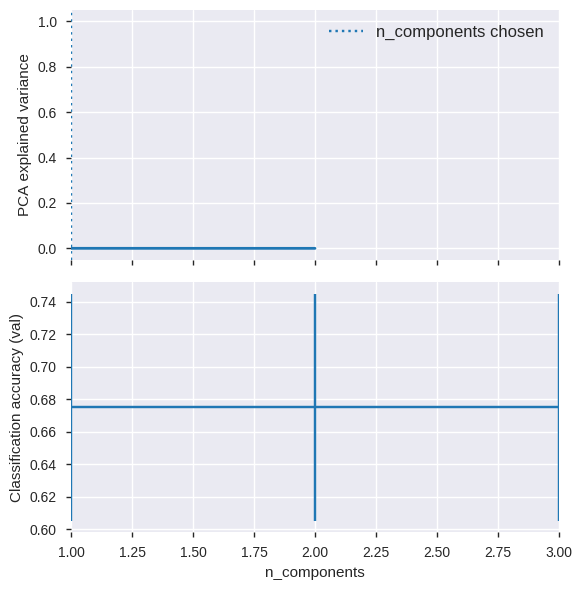

In [0]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X = df.iloc[:, :-1].values
y = df['target'].values

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [1, 2, 3],
    'logistic__alpha': np.logspace(-4, 4, 5),
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=10)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

Dimensionality reduction with PCA reveals that only 1 principal component was chosen to explain the most variance. We, however, will not be using any principal components then for modeling our data, because that gives us too little information.

## Prep the data for modelling

In [0]:
from sklearn.model_selection import train_test_split
from timeit import default_timer

dataframe = pd.DataFrame(new_selected_features)

features = df.iloc[:, :-1].values
target = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [0]:
# scaled features
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.3, random_state=123)
y_train = y_train.ravel()
y_test = y_test.ravel()

## Null Models

Feed the data into a bunch of basic, classic machine learning models right out of the box, with some parameter optimization. We just want to see what we can get out of the box with some of the basic algorithms before going beyond further.

In [0]:
model_performance_df = pd.DataFrame()
model_ids = []
model_type = []
model_parameters = []
model_evaluation_metrics = []
model_score = []

### Logistic Regression Classifier

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score, f1_score, classification_report

# model = LogisticRegression(solver='saga')

param_grid = {"penalty": ["l1", "l2", "elasticnet"],
              "C": np.arange(0., 1.1, 0.1)}

start = default_timer()

gscv = GridSearchCV(estimator=LogisticRegression(solver='saga'), 
                    param_grid=param_grid, 
                    scoring="balanced_accuracy",
                    cv=10,
                    refit=True,
                    error_score=np.nan)

gscv.fit(X_train, y_train)

y_pred = gscv.predict(X_test)
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gscv.score(X_train, y_train)))
end = default_timer()
print("Total training time: {}s".format(end-start))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1. / C
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1. / C
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1. / C
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1. / C
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1. / C
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974: RuntimeWarning: divide by zero encountered in double_scalars
  beta = 1. / C
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:974:

coefficient of determination R^2 of our estimator out of the box: 0.559688219292739
Total training time: 0.6287780869997732s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:

In [0]:
# list of model attributes you print out
print("Best Estimator: \n{}\nBest Score: \n{}\nBest Params: \n{}\nScorer: \n{}".format(
gscv.best_estimator_, 
gscv.best_score_, 
gscv.best_params_, 
gscv.scorer_))

Best Estimator: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Best Score: 
0.5582485596062288
Best Params: 
{'C': 1.0, 'penalty': 'l2'}
Scorer: 
make_scorer(balanced_accuracy_score)


In [0]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
cr = classification_report(y_test, y_pred)
pp.pprint(cr)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.74      0.98      0.84       165\n'
 '           1       0.50      0.07      0.12        60\n'
 '\n'
 '    accuracy                           0.73       225\n'
 '   macro avg       0.62      0.52      0.48       225\n'
 'weighted avg       0.68      0.73      0.65       225\n')


### Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {"n_estimators": [5, 10, 20],
              "max_depth": [3, 4, 5], 
              "min_samples_leaf": [1, 2, 3, 4, 5]}


gscv_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=123, verbose=0, warm_start=True), 
                    param_grid=param_grid, 
                    scoring="balanced_accuracy",
                    cv=10,
                    refit=True,
                    error_score=np.nan)

start = default_timer()
gscv_rfc.fit(X_train, y_train)
y_pred = gscv_rfc.predict(X_test)
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gscv_rfc.score(X_train, y_train)))
end = default_timer()
print("Total training time: {}s".format(end-start))

coefficient of determination R^2 of our estimator out of the box: 0.6919439213224524
Total training time: 7.5175696270002845s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
# random forest classifier class attributes

print("Best Estimator: \n{}\nBest Score: \n{}\nBest Params: \n{}\nScorer: \n{}".format(
gscv_rfc.best_estimator_, 
gscv_rfc.best_score_, 
gscv_rfc.best_params_, 
gscv_rfc.scorer_))

Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=True)
Best Score: 
0.6148481739467142
Best Params: 
{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 5}
Scorer: 
make_scorer(balanced_accuracy_score)


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[152,  13],
       [ 44,  16]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       165
           1       0.55      0.27      0.36        60

    accuracy                           0.75       225
   macro avg       0.66      0.59      0.60       225
weighted avg       0.72      0.75      0.71       225



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.34')

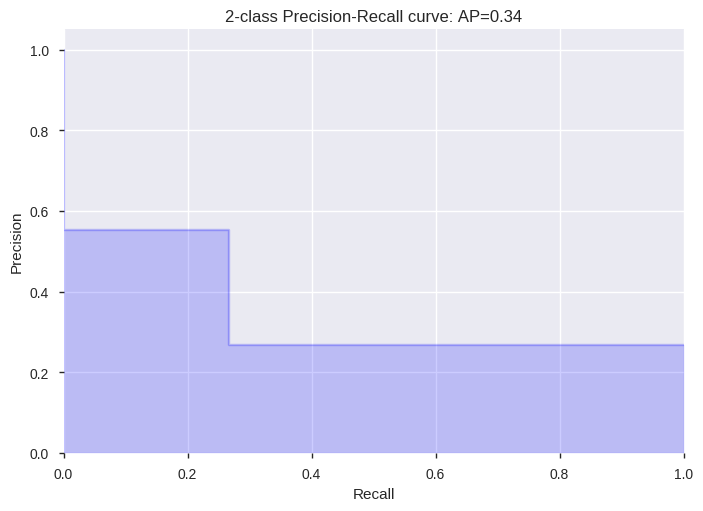

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [0]:
df.target.value_counts()

0    570
1    178
Name: target, dtype: int64

From these null models (with a teensy bit of hyperparameter space searching), we can see that, given the imbalance in the class sizes, we were not able to get a model with a considerably good predictive accuracy score ( lots of negative cases compared to positive cases). We also did not achieve good recall, precision or f-1 scores. Therefore, our other unexplored option would be to employ synthetic data generation through over-sampling of the minority class.

## Over Sampling of Minority class to over comeclass imbalance

In [0]:
!pip install imbalanced-learn -qq

In [0]:
# imbalanced learn processor
from imblearn.over_sampling import SMOTE

def over_sampler(features, target):
    """ use grid search to pick best neighbors for 
    resampler via modeling after resampler and selecting best model
    
    :param features: scaled features
    :param target: target is not scaled
    
     """
    from imblearn.over_sampling import SMOTE

    sm = SMOTE(random_state=42, k_neighbors=21)
    features_res, target_res = sm.fit_resample(features, target)
    return features_res, target_res

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
features_res, target_res = over_sampler(scaled_features, df.iloc[:, -1].values)

In [0]:
from timeit import default_timer

X_train, X_test, y_train, y_test = train_test_split(features_res, target_res, train_size=0.3, random_state=42)

param_grid = {"n_estimators": [40, 42, 43, 45, 50],
              "max_depth": [3, 4, 5], 
              "min_samples_leaf": [1, 2, 3, 4, 5]}


gv = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
start_time = default_timer()
gv.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
end_time = default_timer()
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gv.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gv.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

coefficient of determination R^2 of our estimator out of the box: 0.8567251461988304
ROC AUC score: 0.49753086419753084
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       405
           1       0.00      0.00      0.00       393

    accuracy                           0.51       798
   macro avg       0.25      0.50      0.34       798
weighted avg       0.26      0.51      0.34       798

Accuracy Score: 0.5050125313283208
F1 Score: 0.0
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
T

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Got an F-1 score of 0.0... I don't know what happened there but that is horrifying.

In [0]:
model_ids = []
best_estimators = []
best_parameters = []
precision = []
recall = []
accuracy = []
roc_auc = []
r2 = []
train_time = []

model_ids.append("001")
best_estimators.append(gv.best_estimator_)
best_parameters.append(gv.best_params_)
precision.append(precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
accuracy.append(accuracy_score(y_test, y_pred))
roc_auc.append(roc_auc_score(y_test, y_pred))
r2.append(gv.score(X_test, y_test))
train_time.append(f"{end_time-start_time}")

best_models_df = pd.DataFrame()
best_models_df['id'] = model_ids
best_models_df['best_estimator'] = best_estimators
best_models_df['best_parameters'] = best_parameters
best_models_df['accuracy'] = accuracy
best_models_df['precision'] = precision
best_models_df['recall'] = recall
best_models_df['roc_auc'] = roc_auc
best_models_df['r2_score'] = r2
best_models_df['train_time(s)'] = train_time

In [0]:
best_models_df.head()

,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,001,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.505013,0.0,0.0,0.497531,0.720551,41.63667466600009


In [0]:
from sklearn.metrics import confusion_matrix as cm
cm = cm(y_test, y_pred, labels=None, sample_weight=None)
cm

array([[403,   2],
       [393,   0]])

In [0]:
def plot_roc(y_test, y_pred, n_classes=2):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operator Characteristic Curce')
    plt.legend(loc="lower right")
    plt.show()

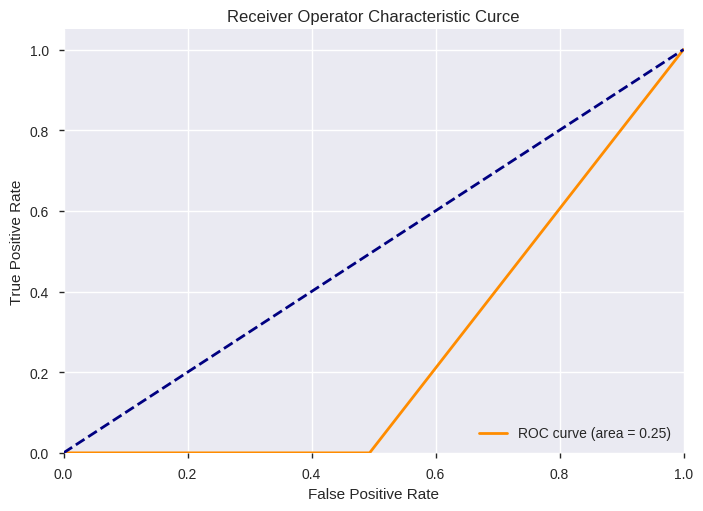

In [0]:
plot_roc(y_pred, y_test)

We got back a model that is worse than the null model essentially... We would have had better performance if we predicted "did not donate blood in May of 2007" for every instance before class balancing.

## XGBoost

In [0]:
!pip install xgboost -qq

In [0]:
from xgboost import XGBClassifier
from xgboost.callback import early_stop

X_train, X_test, y_train, y_test = train_test_split(features_res, target_res, train_size=0.3, random_state=42)

param_grid = {"n_estimators": [50, 80, 100],
              "learning_rate": [0.001, 0.01, 0.05],
              "max_depth": [3, 4, 5], 
              "booster": ["gbtree", "dart"],
              "reg_lambda": [0.4, 0.5, 0.8]
              }

gv_xgb = GridSearchCV(XGBClassifier(random_state=42, verbosity=1), param_grid, cv=10)
start_time = default_timer()
gv_xgb.fit(X_train, y_train, callbacks=[early_stop])
y_pred = gv_xgb.predict(X_test)
end_time = default_timer()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gv_xgb.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gv_xgb.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

coefficient of determination R^2 of our estimator out of the box: 0.9093567251461988
ROC AUC score: 0.7448968052021487
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       405
           1       0.77      0.70      0.73       393

    accuracy                           0.75       798
   macro avg       0.75      0.74      0.74       798
weighted avg       0.75      0.75      0.74       798

Accuracy Score: 0.7456140350877193
F1 Score: 0.729693741677763
Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=0.4, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
T

In [0]:
xgb_perf = pd.DataFrame({"id":["002"], 
        "best_estimator":f"{gv_xgb.best_estimator_}", 
        "best_parameters":f"{gv_xgb.best_params_}", 
        "accuracy":[accuracy_score(y_test, y_pred)], 
        "precision":[precision_score(y_test, y_pred)], 
        "recall":[recall_score(y_test, y_pred)], 
        "roc_auc":[roc_auc_score(y_test, y_pred)], 
        "r2_score":[gv_xgb.score(X_train, y_train)],
        "train_time(s)": f"{end_time-start_time}"
        })

xgb_perf

,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,002,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'booster': 'gbtree', 'learning_rate': 0.05, '...",0.745614,0.765363,0.697201,0.744897,0.909357,279.95699066099996


In [0]:
new_df = pd.concat([best_models_df, xgb_perf]).reset_index()
new_df.head()

,index,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,0,001,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.505013,0.000000,0.000000,0.497531,0.720551,41.63667466600009
1,0,002,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'booster': 'gbtree', 'learning_rate': 0.05, '...",0.745614,0.765363,0.697201,0.744897,0.909357,279.95699066099996


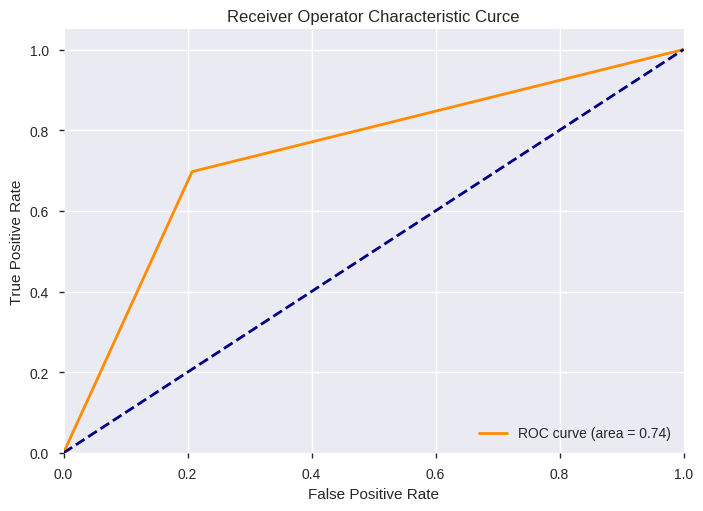

In [0]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curce')
plt.legend(loc="lower right")
plt.show()

## AdaBoost Classifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

param_grid = {"base_estimator":[DecisionTreeClassifier(), SVC(gamma="auto"), GaussianNB()],
              "n_estimators": [20, 30, 40, 42],
              "learning_rate": [0.001, 0.01, 0.1]
              }

gcv_adaboost = GridSearchCV(AdaBoostClassifier(algorithm="SAMME", random_state=42), param_grid, cv=10)
start_time = default_timer()
gcv_adaboost.fit(X_train, y_train)
y_pred = gcv_adaboost.predict(X_test)
end_time = default_timer()
print("coefficient of determination R^2 of our estimator out of the box: {}".format(gcv_adaboost.score(X_train, y_train)))
print("ROC AUC score: {}".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Best Estimator: {}".format(gcv_adaboost.best_estimator_))
print("Time to train: {}s".format(end_time - start_time))

coefficient of determination R^2 of our estimator out of the box: 0.9766081871345029
ROC AUC score: 0.7167561963999622
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       405
           1       0.76      0.63      0.69       393

    accuracy                           0.72       798
   macro avg       0.72      0.72      0.72       798
weighted avg       0.72      0.72      0.72       798

Accuracy Score: 0.7180451127819549
F1 Score: 0.6879334257975034
Best Estimator: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         m

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
adaboost_perf = pd.DataFrame({"id":["003"], 
        "best_estimator":f"{gcv_adaboost.best_estimator_}", 
        "best_parameters":f"{gcv_adaboost.best_params_}", 
        "accuracy":[accuracy_score(y_test, y_pred)], 
        "precision":[precision_score(y_test, y_pred)], 
        "recall":[recall_score(y_test, y_pred)], 
        "roc_auc":[roc_auc_score(y_test, y_pred)], 
        "r2_score":[gcv_adaboost.score(X_train, y_train)],
        "train_time(s)":f"{end_time-start_time}"
        })

adaboost_perf

,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,003,"AdaBoostClassifier(algorithm='SAMME',\n ...",{'base_estimator': DecisionTreeClassifier(clas...,0.718045,0.756098,0.631043,0.716756,0.976608,41.971122539000135


In [0]:
performance_df = pd.concat([new_df, adaboost_perf], sort=False).reset_index()
performance_df.head()

,level_0,index,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,0,0.0,001,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.505013,0.000000,0.000000,0.497531,0.720551,41.63667466600009
1,1,0.0,002,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'booster': 'gbtree', 'learning_rate': 0.05, '...",0.745614,0.765363,0.697201,0.744897,0.909357,279.95699066099996
2,0,NaN,003,"AdaBoostClassifier(algorithm='SAMME',\n ...",{'base_estimator': DecisionTreeClassifier(clas...,0.718045,0.756098,0.631043,0.716756,0.976608,41.971122539000135


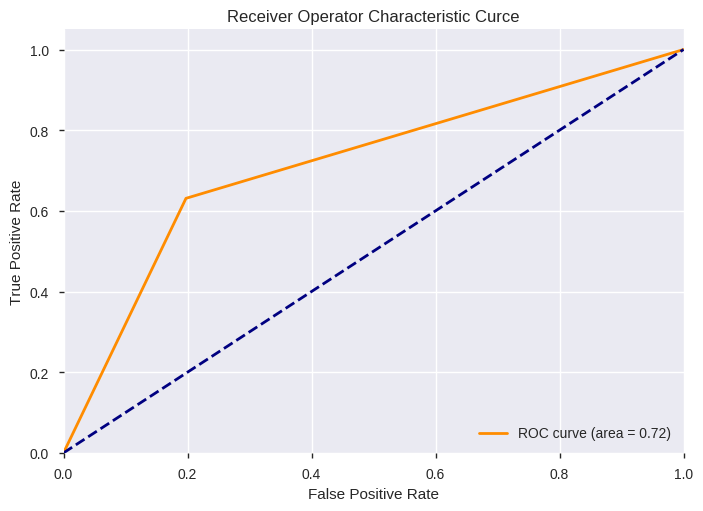

In [0]:
plot_roc(y_test, y_pred)

### LIME algorithm and simple 

The Lime Algorithm allows us to have a little bit more interpretability in terms of the labels that we predict. LIME - Local Interpretable Model-Agnostic Explanations, meaning that our predicted explanations for our predictions can be explained through our prediction's relation to its neighboring (distance-wise) observations in a feature space.

We can use the Tabular Explainer class in the LIME library to have a look at some of the predictions we have made and what features attribute the most neighborhood similarity to our predicted class.

In [0]:
!pip install lime -qq

     |████████████████████████████████| 276kB 2.8MB/s 


In [0]:
rescaled_df = pd.DataFrame(np.c_[features_res, target_res], columns=df.columns)
rescaled_df.head()

,Recency (months),Monetary (c.c. blood),Time (months),target
0,-0.927899,7.623346,2.615633,1.0
1,-1.175118,1.282738,-0.257881,1.0
2,-1.051508,1.796842,0.029471,1.0
3,-0.927899,2.482313,0.439973,1.0
4,-1.051508,3.167784,1.753579,0.0


In [0]:
from lime.lime_tabular import LimeTabularExplainer

lte = LimeTabularExplainer(X_train, mode='classification', training_labels=["0", "1"], feature_names=rescaled_df.columns[:-1], 
                           verbose=True, class_names=["target"], feature_selection='auto')

# lte.show_in_notebook(labels=None, predict_proba=True, show_predicted_value=True, **kwargs)

Intercept 0.5213086210720609
Prediction_local [0.6511722]
Right: 0.6734077906336553


IndexError: ignored

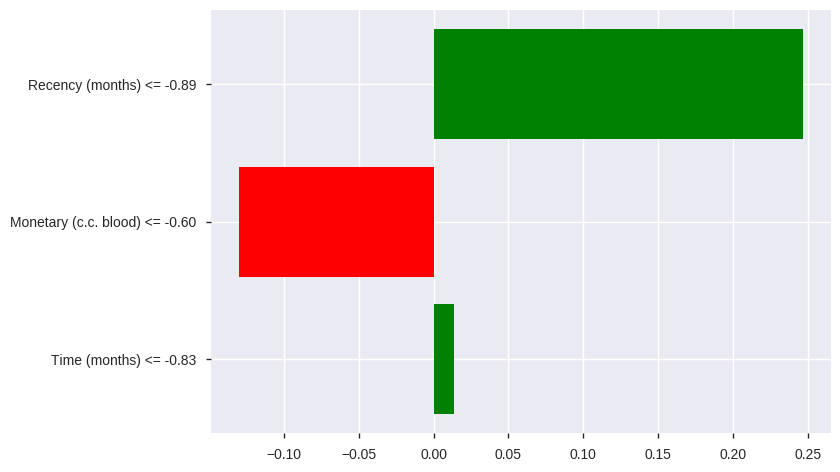

In [0]:
nb = GaussianNB().fit(X_train, y_train)

exp = lte.explain_instance(X_test[3], nb.predict_proba,
        num_features=rescaled_df.shape[1]-1, num_samples=rescaled_df.shape[0], 
        distance_metric='euclidean', model_regressor=None)

exp.as_pyplot_figure()
plt.tight_layout()

For the 4th test observation, the Receny of blood donation contributes the majority of the 'say' to the prediction swaying in favor of 'yes, did donate blood in May 2007".

Intercept 0.442697497011486
Prediction_local [0.90316514]
Right: 0.7862145901585166


IndexError: ignored

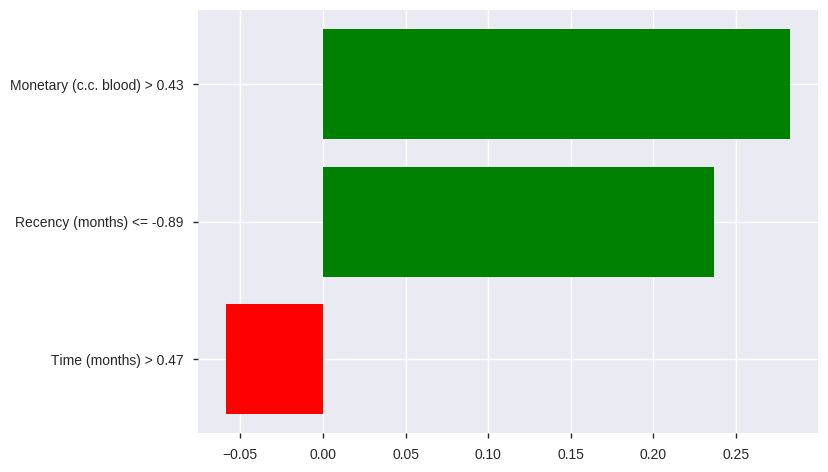

In [0]:
exp = lte.explain_instance(X_test[5], nb.predict_proba,
        num_features=rescaled_df.shape[1]-1, num_samples=rescaled_df.shape[0], 
        distance_metric='euclidean', model_regressor=None)

exp.as_pyplot_figure()
plt.tight_layout()

The sixth test sample is predicted to have donated blood in May 2007 due to the amount of blood that they have donated as well as how recently they donated blood.

Intercept 0.7022037945909345
Prediction_local [0.02432061]
Right: 0.010669774172572791


IndexError: ignored

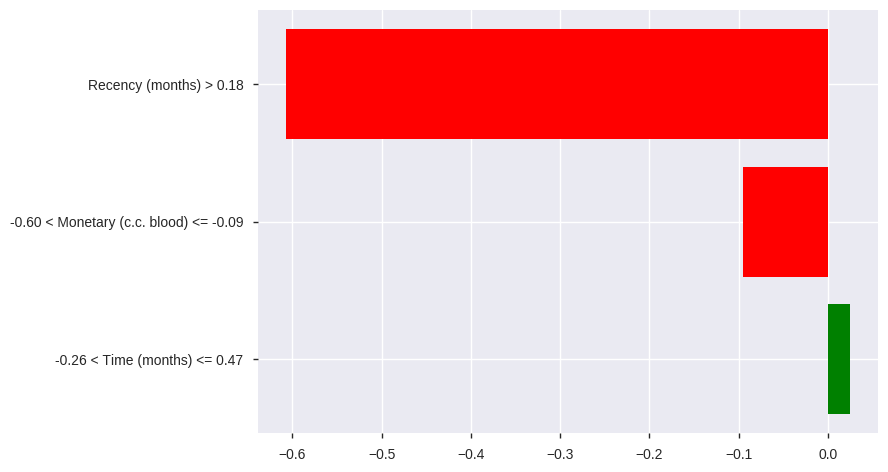

In [0]:
exp = lte.explain_instance(X_test[19], nb.predict_proba,
        num_features=rescaled_df.shape[1]-1, num_samples=X_test.shape[0], 
        distance_metric='euclidean', model_regressor=None)

exp.as_pyplot_figure()
plt.tight_layout()

The 20th text observation is predicted to not have donated blood in May 2007, majorly attributable to the fact that the number of months since they donated blood is larger in comparison to the neighboring test observations.

That was just a taste of the power of the LIME model and how we can explain some of the contributions of our predictions.

## Model Selection and Evaluation Pipeline

In [0]:
# install feature selection and model selection pipeline libraries
!pip install mlxtend -qq
!pip install tpot -qq

     |████████████████████████████████| 901kB 2.8MB/s 
     |████████████████████████████████| 153kB 57.1MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 


### Model Selection using TPOT

In [0]:
from tpot import TPOTClassifier

tpot_classifier = TPOTClassifier(generations=30, population_size=100, cv=10, random_state=42, verbosity=1, memory='auto')

start_time = default_timer()
tpot_classifier.fit(X_train, y_train)
print("TPOT Score: {}".format(tpot_classifier.score(X_test, y_test)))
y_pred = tpot_classifier.predict(X_test)
end_time = default_timer()

runtime = end_time - start_time

print(f"Total runtime for the Employee dataset: {runtime}s")

Best pipeline: XGBClassifier(CombineDFs(LinearSVC(CombineDFs(CombineDFs(StandardScaler(input_matrix), input_matrix), input_matrix), C=0.0001, dual=False, loss=squared_hinge, penalty=l2, tol=1e-05), input_matrix), learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.45)
TPOT Score: 0.7418546365914787
Total runtime for the Employee dataset: 3245.891771926s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validat

In [0]:
tpot_classifier.export('tpot_exported_pipeline.py')

In [0]:
# 3809.0180992140013
# XGBClassifier(CombineDFs(LinearSVC(CombineDFs(CombineDFs(StandardScaler(input_matrix), input_matrix), input_matrix), C=0.0001, dual=False, loss=squared_hinge, penalty=l2, tol=1e-05), input_matrix), learning_rate=0.5, max_depth=9, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.45)

In [0]:
# print("Best Estimator: \n{}\nBest Score: \n{}\nBest Params: \n{}\nScorer: \n{}".format(
# tpot_classifier.best_estimator_, 
# tpot_classifier.tpot_regressor.score, 
# tpot_classifier.best_params_, 
# tpot_classifier.scorer_))

In [0]:
from sklearn.metrics import r2_score

tpot_perf = pd.DataFrame({"id":["004"], 
        "best_estimator":f"{tpot_classifier.fitted_pipeline_}", 
        "best_parameters":f"{tpot_classifier.get_params}", 
        "accuracy":[tpot_classifier.score(X_train, y_train)], 
        "precision":[precision_score(y_test, y_pred)], 
        "recall":[recall_score(y_test, y_pred)], 
        "roc_auc":[roc_auc_score(y_test, y_pred)], 
        "r2_score":[r2_score(y_test, y_pred)],
        "train_time(s)":f"{end_time-start_time}"
        })

tpot_perf

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,004,Pipeline(memory=Memory(location=/tmp/tmphuhixk...,<bound method BaseEstimator.get_params of TPOT...,0.888889,0.753388,0.707379,0.741344,-0.032815,3245.891771926


In [0]:
all_perf_df = pd.concat([performance_df, tpot_perf], sort=False, ignore_index=True).reset_index(drop=True)

,level_0,index,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,0.0,0.0,001,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.505013,0.000000,0.000000,0.497531,0.720551,41.63667466600009
1,1.0,0.0,002,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'booster': 'gbtree', 'learning_rate': 0.05, '...",0.745614,0.765363,0.697201,0.744897,0.909357,279.95699066099996
2,0.0,NaN,003,"AdaBoostClassifier(algorithm='SAMME',\n ...",{'base_estimator': DecisionTreeClassifier(clas...,0.718045,0.756098,0.631043,0.716756,0.976608,41.971122539000135
3,NaN,NaN,004,Pipeline(memory=Memory(location=/tmp/tmphuhixk...,<bound method BaseEstimator.get_params of TPOT...,0.888889,0.753388,0.707379,0.741344,-0.032815,3245.891771926


In [0]:
all_perf_df.drop(['level_0', 'index'], axis=1, inplace=True)
all_perf_df.head()

,id,best_estimator,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,001,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",0.505013,0.000000,0.000000,0.497531,0.720551,41.63667466600009
1,002,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'booster': 'gbtree', 'learning_rate': 0.05, '...",0.745614,0.765363,0.697201,0.744897,0.909357,279.95699066099996
2,003,"AdaBoostClassifier(algorithm='SAMME',\n ...",{'base_estimator': DecisionTreeClassifier(clas...,0.718045,0.756098,0.631043,0.716756,0.976608,41.971122539000135
3,004,Pipeline(memory=Memory(location=/tmp/tmphuhixk...,<bound method BaseEstimator.get_params of TPOT...,0.888889,0.753388,0.707379,0.741344,-0.032815,3245.891771926


In [0]:
all_perf_df.to_csv("blood_transfusion_prediction_experiments.csv")

# Conclusion and Reflections

All this, for what? This was a relatively contrive and simple dataset that I had initally thought would be fairly simple to explore and model, however, in the end, I made this little experiment to be much more complicated than it had to be with some testing of various null models, feature selection, profiling, EDA, data augmentation, over sampling, model selection, and hyperparameter selection.

This is a good example of me just being a little curious and trying out new things and going that extra mile to have fun and curiosity in the types of modeling and tooling out there for predictive analytics that can be applied to any type of machine learning problem. This is just a simple flat file that wasn't too big of a deal, but it was fun going through all that.

Note: That feeling when a model selection process throws an error or freezes because of a timeout or some other error...oof.